# Trial-by-trial classifier prediction confidence and effects of time selection

Look at the trial-by trial classifier prediction confidence and test whether effects are influenced by time-window of interest selection

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("white")
sns.set_context('paper')

import mne
from autoreject import LocalAutoRejectCV
mne.set_log_level('ERROR')

import pandas as pd
import scipy.stats as stats
from os import listdir
import numpy as np
import pickle

loc_files = "/.../n4-p6/" # location of saved epochs
template = loc_files+"{}-epo.fif" # template to load epochs

bads = ["VLA21", # not a native speaker of German
        "GMA05","RAC22","PBT16","HHA01","BSN17"]

names = list({fname.split("-")[0]  # list of participant IDs
              for fname in listdir(loc_files) 
              if "epo" in fname and fname.split("-")[0] not in bads
             })
savs = "/.../" # location of saved decoder scores+prediction confidence dictionary

/data/home1/eheikel/tools/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [61]:
# load previously calculated(and saved) scores
with open(savs+'scores.pckl', 'rb') as f:
        scores_dict = pickle.load(f)

In [62]:
def get_epochs(name):
    '''
    loads the epoched data for participant (name)
    '''
    
    epoch = mne.read_epochs(template.format(name))
    return epoch

times = get_epochs(names[0]).times
l_times = list(times)

In [63]:
def sorted_by_pred_conf(score, tmin, tmax, tmin2, tmax2):

    '''Sorts condidence scores within time window of interest, the reason for 4 time specification is that you could
    in principle average in one time window and sort by another time windows classifier performance. E.g. Sort N400
    classifier performance by P600 strength with (.3, .5, .6, .8). Currently, sorting and averaging within respective
    time windows only.
    '''
    
    from scipy.misc import imresize
    l_times = list(get_epochs(names[0]).times)

    # Get trial order by average confidence strength within time window of interest
    tmin, tmax = l_times.index(tmin), l_times.index(tmax)
    trials = score.T[tmin:tmax, :, :].mean(0)
    order = trials[tmin:tmax, :].mean(0).argsort() 
    
    # sort trials and average prediction confidence over time
    tmin3, tmax3 = l_times.index(tmin2), l_times.index(tmax2)
    trials2 = score.T[tmin3:tmax3, :, :].mean(0)
    output_image = imresize((trials2[:, order].T), (80, 161)) # 80 trials by 161 time points (-.3 -> 1.3)
    
    return output_image/255

/data/home1/eheikel/tools/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  app.launch_new_instance()


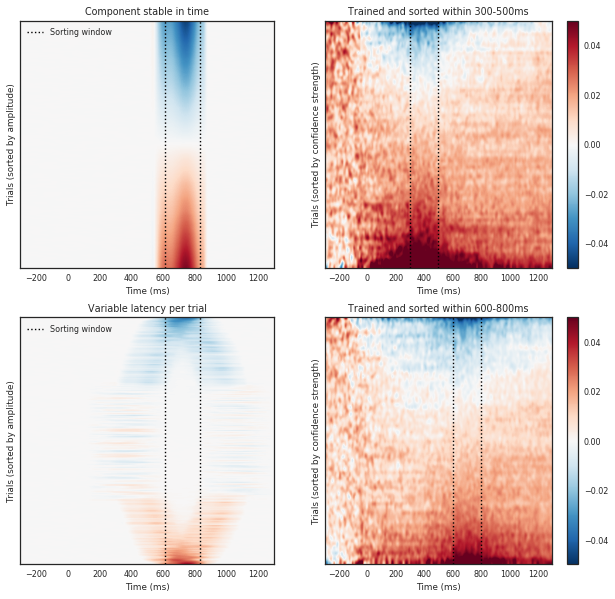

In [64]:
# trial-by-trial simulations and data for N400 and P600 data using confidence scores (i.e. distance from hyper-plane\0
%matplotlib inline
from itertools import combinations
from scipy.spatial import Delaunay
from scipy.sparse import csr_matrix
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import mne
from mne.datasets import testing
from mne.channels.layout import _find_topomap_coords
from mne.stats.cluster_level import spatio_temporal_cluster_1samp_test as tst
from mpl_toolkits.axes_grid1 import make_axes_locatable

# data_path directs towards MNE example EEGLAB data
data_path = testing.data_path()
fname = data_path + "/EEGLAB/test_raw.set"
montage = data_path + "/EEGLAB/test_chans.locs"

event_id = {"rt":1, "square":2}
eog = {"FPz", "EOG1", "EOG2"}
raw = mne.io.eeglab.read_raw_eeglab(fname, preload=True, eog=eog,
                                    montage=montage, event_id=event_id
                                   ).filter(1, None).resample(100)
events = mne.find_events(raw)
picks = mne.pick_types(raw.info, eeg=True)
epochs = mne.Epochs(raw, events, {"square":2, "rt": 1}, tmax=1., picks=picks, preload=True)
epochs.crop(.3, None)

# prediction confidence scores (above and below 0, degree of confidence is the distance from 0)
predicts = np.asarray(scores_dict["ridge"]["predicts"])

d = epochs["square"].average().crop(.2, .5).data
d.shape
nchans, ntimes = d.shape
times = np.random.randint(1000, raw.n_times - 1000, 5000)
on_correlations=False

sns.set_context('paper')
fig, axes = plt.subplots(ncols=2, nrows=2)
fig.set_size_inches((10, 10))

for ax, do_t in zip(axes[:, 0], [True, False]):
    draw = raw._data.copy()

    d2 = np.array([draw[:nchans, time_-50:time_+50] for time_ in times])

    draw = raw._data.copy()

    d2 = np.array([draw[:nchans, time_-50:time_+50] for time_ in times])
    ts = []
    for ii, trial in enumerate(d2):
        t = np.random.randint(25, 100-ntimes)
        ts.append(t)
        if do_t is True:
            t = np.mean((25, 100-ntimes)).astype(int)
        randn_ = np.random.uniform(-1.5, 1.5)
        d2[ii, :, t:t+ntimes] += (d * 50) * randn_
    d3 = d2.mean(1)
    d3.shape

    tmean = int(np.mean(ts)) + d.mean(0).argmax()
    start, end = (tmean-7), (tmean+7)
    order = d3[:, tmean-7:tmean+7].mean(1).argsort()

    mx = 0.0015
    
    ax.imshow(d3[order, :], aspect="auto",origin='upper', cmap="RdBu_r", interpolation="bicubic",
              extent=(-300, 1300, 0, 1), vmin=-mx, vmax=mx),
    t0, t1 = (start) / 100, (end) / 100
    ax.plot((t0*1600-300, t0*1600-300), (0, 1), color="k", linestyle=":", label="Sorting window") 
    ax.plot((t1*1600-300, t1*1600-300), (0, 1), color="k", linestyle=":")

    ax.set_ylabel("Trials (sorted by amplitude)")
    ax.set_xlabel("Time (ms)")
    ax.set_yticks([])
    if not on_correlations:
        ax.set_title("Component stable in time" if do_t else "Variable latency per trial")
    ax.legend()
    
n1, n2, p1, p2 = .3, .5, .6, .8 
all_times = [(n1, n2, n1, n2),(p1, p2, p1, p2)]
labels= ['Trained and sorted within 300-500ms', 'Trained and sorted within 600-800ms']
for ax, tims, label in zip(axes[:, 1], all_times, labels):
    
    d = np.asarray([sorted_by_pred_conf(p, *tims) for p in predicts])-.5
    img = ax.imshow((np.array(d).mean(0)),origin="upper", cmap="RdBu_r",
                        aspect="auto", interpolation="bicubic", extent=[-300, 1300, 0, 80],
                        vmin=-.05, vmax=.05);
    
    ax.set_ylabel("Trials (sorted by confidence strength)")
    ax.set_yticks([])
    ax.set_title(label)
    ax.vlines(tims[0]*1000,ymin=0, ymax=80, linestyles="dotted")
    ax.vlines(tims[1]*1000,ymin=0, ymax=80, linestyles="dotted")
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.2)
    fig.colorbar(img, cax=cax)
    
    ax.set_xlabel("Time (ms)")

In [424]:
fig.savefig(savs + "prediction_scores.pdf")

# See if different P600 time windows make a difference 

In [6]:
# statistics tests used, thanks to Jean-Rémi King

def _my_wilcoxon(X):
    from scipy.stats import wilcoxon
    out = wilcoxon(X)
    return out[1]

def _loop(x, function):
    out = list()
    for ii in range(x.shape[1]):
        out.append(function(x[:, ii]))
    return out

def parallel_stats(X, function=_my_wilcoxon, correction='FDR', n_jobs=-1):
    from mne.parallel import parallel_func
    import numpy as np
    from mne.stats import fdr_correction

    if correction not in [False, None, 'FDR']:
        raise ValueError('Unknown correction')
    # reshape to 2D
    X = np.array(X)
    dims = X.shape
    X.resize([dims[0], np.prod(dims[1:])])
    # prepare parallel
    n_cols = X.shape[1]
    parallel, pfunc, n_jobs = parallel_func(_loop, n_jobs)
    n_chunks = min(n_cols, n_jobs)
    chunks = np.array_split(range(n_cols), n_chunks)
    p_values = parallel(pfunc(X[:, chunk], function) for chunk in chunks)
    p_values = np.reshape(np.hstack(p_values), dims[1:])
    X.resize(dims)
    # apply correction
    if correction == 'FDR':
        dims = p_values.shape
        _, p_values = fdr_correction(p_values)
        p_values = np.reshape(p_values, dims)
    return p_values

In [7]:
def grouper(iterable):
    """List of time points of significance, identifies neighbouring time points"""
    prev = None
    group = []
    for item in iterable:
        if not prev or round(item - prev, 2) <= .01:
            group.append(item)
        else:
            yield group
            group = [item]
        prev = item
    if group:
        yield group
        
def find_clus(sig_times):
    """Identify time points of significance from FDR correction, results in lists of ranges and individual 
        time points of significance. Creates a dictionary for later use.
    
    Parameters
    ----------
    sig_times: list
        List of significant time points
    """
    group = dict(enumerate(grouper(sig_times)))
    clus = []
    for key in group.keys():   
        ls = group[key]
        clus.append((([ls[0], ls[-1]] if round((ls[1]-ls[0]), 2)<=0.01 else [ls[1], ls[-1]]) 
                     if len(group[key])>1 else group[key]))
    return clus

In [8]:
def get_stats_lines (scores, n4_times=[.3, 0.5], p6_times=[0.6, 0.8], alphas=[0.05, 0.01]):
    """Calculate subject level decoder performances for each of the times series plots and 
    perform FDR correction (p<0.05 and p<0.01). Creates a dictionary of relevant stats.
    
    Parameters
    ----------
    
    scores: array
    n4_times: list
        List of tmin and tmax for N400 time window
    p6_times: list
        List of tmin and tmax for P600 time window
    alphas: list
        List of alphas for significance masking default masks for p<0.05 and p<0.01
    """
    
    times = get_epochs(names[0]).times
    l_times, xx = list(times), np.meshgrid(times)[0]
    n4_min, n4_max, p6_min, p6_max = [l_times.index(t) for t in n4_times+p6_times]
    alpha1, alpha2 = alphas
    
    # average classifier performance over time for time window of interest for each subject
    n4 = scores[:, n4_min:n4_max, :].mean(1) 
    p6 = scores[:, p6_min:p6_max, :].mean(1)

    # FDR correction and significance testing
    n4_pvalues = parallel_stats(list(n4-0.5)) 
    p6_pvalues = parallel_stats(list(p6-0.5))

    # mask time points of significance that are p<0.05 (alpha1) and p<0.01 (alpha2)
    n1, n2  = xx[n4_pvalues<alpha1], xx[n4_pvalues<alpha2] 
    p1, p2  = xx[p6_pvalues<alpha1], xx[p6_pvalues<alpha2]

    # get the diagonal (training_t==testing_t) for each subject, FDR correction, and mask time points of significance
    diag = np.asarray([sc.diagonal() for sc in scores])
    diag_pvalues = parallel_stats(list(diag-0.5))
    diag1, diag2  = xx[diag_pvalues<alpha1], xx[diag_pvalues<alpha2]

    #average difference between classifier performance over time for time window of interest for each subject
    diff = np.array([(sc[p6_min:p6_max].mean(0) -
                          sc[n4_min:n4_max].mean(0)) # subtract N400 from P600 decoders
                         for sc in scores])
    #FDR correction and significance masking
    diff_pvalues = parallel_stats(list(diff))
    diff1, diff2  = xx[diff_pvalues<alpha1], xx[diff_pvalues<alpha2]
    
    #create dict of stats
    stats_dict = {"N400": [n4, n1, n2], "P600":[p6, p1, p2], "diag":[diag, diag1, diag2], "diff":[diff, diff1, diff2]}
    return stats_dict

In [117]:
def get_dfs(stats_dict, df_type=False):
    """Create DataFrames for time series plotting"""
    if not df_type:
        # create dataframe for N400 and P600 decoders
        df = pd.DataFrame()
        sub, time, accuracy, comp=[], [], [], []
        for c in ["N400", "P600"]:
            for ii, s in enumerate(stats_dict[c][0]):
                for t, a in enumerate(s):
                    sub.append(ii), accuracy.append(a), time.append(times[t]), comp.append(c)
        df["Time (s)"], df["Subject"], df["Accuracy (%)"], df["Component"] = time, sub, accuracy, comp

    else:
        # create dataframe for diagonal or difference between N400&P600
        sub, time, ac=[], [], []
        df = pd.DataFrame()
        for ii, s in enumerate(stats_dict[df_type][0]):
            for t, a in enumerate(s):
                sub.append(ii), ac.append(a), time.append(times[t])
        df["Time (s)"], df["Subject"] = time, sub
        df["{}".format(("Accuracy (%)" if df_type=="diag" else "Difference in Accuracy (%)"))] = ac
 
    return df

In [115]:
def calc_xval(clus):
    """calculate xmin and xmax for axvlines to indicate time points of significance"""
    return {"xmin":(clus[0]+0.3)/1.6, "xmax":(clus[-1]+(0.3 if len(clus)!=1 else 0.301))/1.6}

def plot_images(stats_temp, ax, df_type):
    if df_type=="diff":
    # plot difference between decoders
        plt_ = sns.tsplot(data=get_dfs(stats_temp, df_type=df_type), time="Time (s)", ax=ax,
                           ci=[95],  color="k",
                           unit="Subject", condition=None,
                              value="Difference in Accuracy (%)")
        plt_.title.set_text("Difference between N400 and P600 decoding; P600 = {} to {}".format(str(tims[0]), 
                                                                                             str(tims[1])))
        plt_.axvline(0, color="k", lw=0.5)
        plt_.axhline(0, color="k", lw=0.5)
        plt_.set_ylim(-0.08, 0.08)
        plt_.axvline(0.5, color="k", linestyle="--", lw=0.5)
        plt_.axvline(0.6, color="k", linestyle="--", lw=0.5)
        plt_.tick_params("both", labelsize=10)

        for it in [1, 2]: #FDR
            for clus in find_clus(stats_temp["diff"][it]):
                if type(clus)!=np.float64:
                        plt_.axhline(-0.06, color=("green" if clus[-1] <.5 else "midnightblue"), 
                                         lw=(1 if it==1 else 3), **calc_xval(clus))

        if fill:
            plt_.fill_betweenx([-0.8, 0.8], 0.3, 0.5, alpha=0.2, color="green")
            plt_.fill_betweenx([-0.8, 0.8], 0.6, 0.8, alpha=0.2, color="blue")

    else: # component generalization
        plt_ = sns.tsplot(data=get_dfs(stats_temp, df_type), time="Time (s)", ax=ax,
               ci=[95],  color=("green", "midnightblue"),
               unit="Subject", legend=True,
           condition="Component", value="Accuracy (%)")

        plt_.title.set_text(("Component Generalization; P600 = {} to {}".format(str(tims[0]), 
                                             str(tims[1]))))
        plt_.axvline(0, color="k", lw=0.5)
        plt_.axhline(0.5, color="k", lw=0.5)
        plt_.axvline(0.5, color="k", linestyle="--", lw=0.5)
        plt_.axvline(0.6, color="k", linestyle="--", lw=0.5)
        plt_.tick_params("both", labelsize=10)
        plt_.set_ylim(0.45, 0.62)
        if fill:
            plt_.fill_betweenx([0.45, 0.62], 0.3, 0.5, alpha=0.2, color="green")
            plt_.fill_betweenx([0.45, 0.62], tims[0], tims[1], alpha=0.2, color="blue")

        params = {"N400":{"val":0.47, "color":"green"}, "P600":{"val":0.48, "color":"midnightblue"}}
        for key in params.keys():
            for it in [1, 2]: # Indicates whether p<0.01 or 0.05, respectively. Influence line thickness
                for clus in find_clus(stats_temp[key][it]):
                    if type(clus)!=np.float64:
                        plt_.axhline(params[key]["val"], color=params[key]["color"], 
                                        lw=(1 if it==1 else 3), **calc_xval(clus))
    return plt_

/data/home1/eheikel/tools/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)
/data/home1/eheikel/tools/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


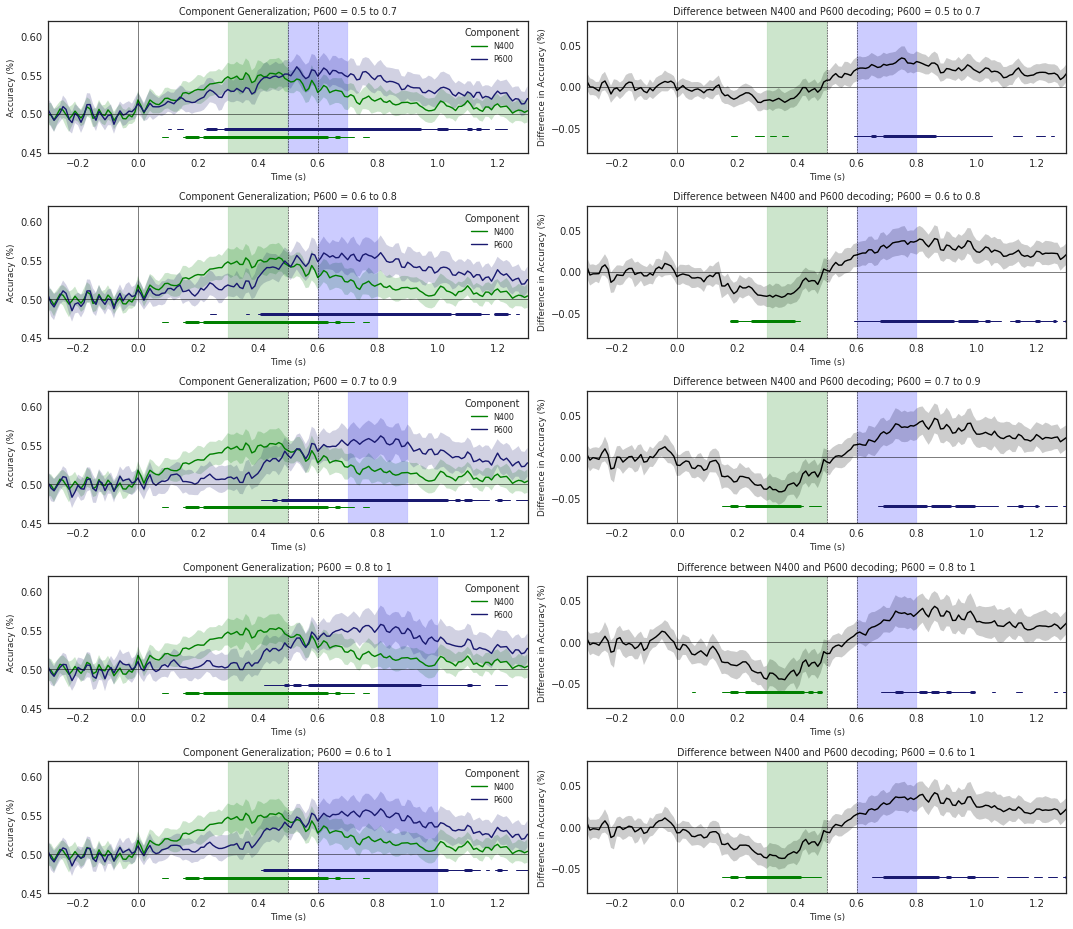

In [118]:
fig, axes = plt.subplots(5, 2)

fig.set_size_inches(15,13)
fig.set_tight_layout("tight")


fill=True
p_times = [[.5, .7], [.6, .8],[.7,.9],[.8, 1], [.6,1]]

times = get_epochs(names[0]).times
l_times = list(times)

scores = scores_dict["ridge"]["scores"]
for ax_, tims in zip(axes, p_times):
    for ax, df_type in zip(ax_, [False, "diff"]):
        plot_images(get_stats_lines(np.asarray(scores), [.3, .5], tims), ax, df_type)